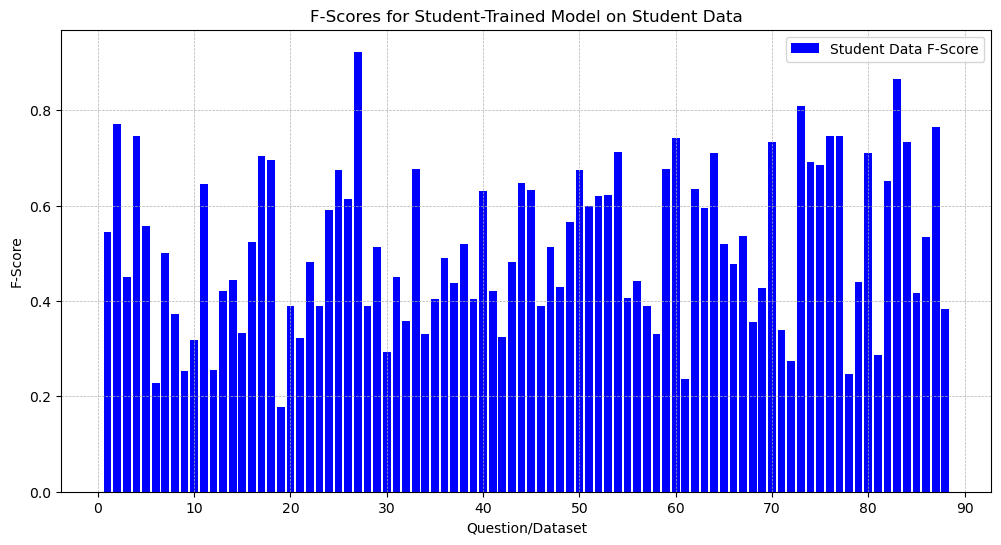

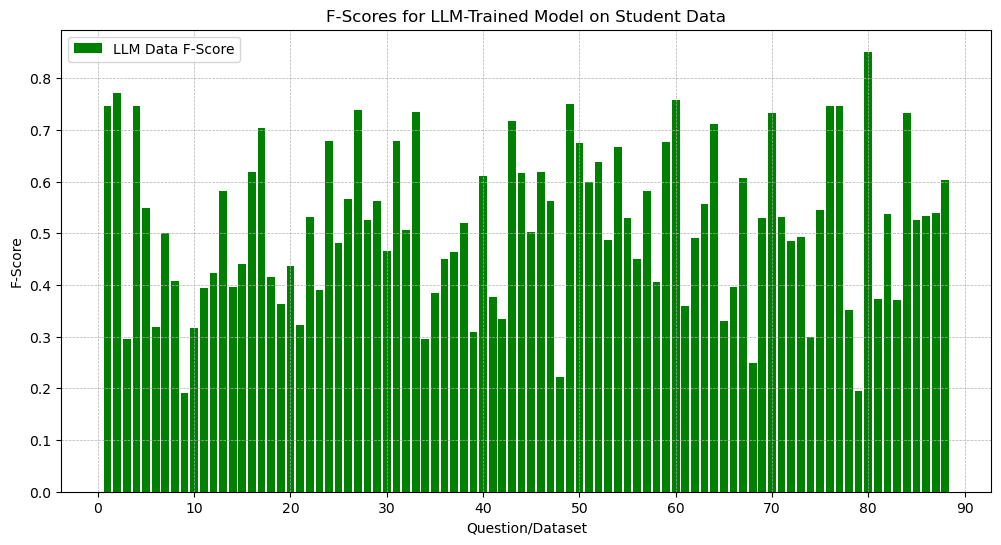

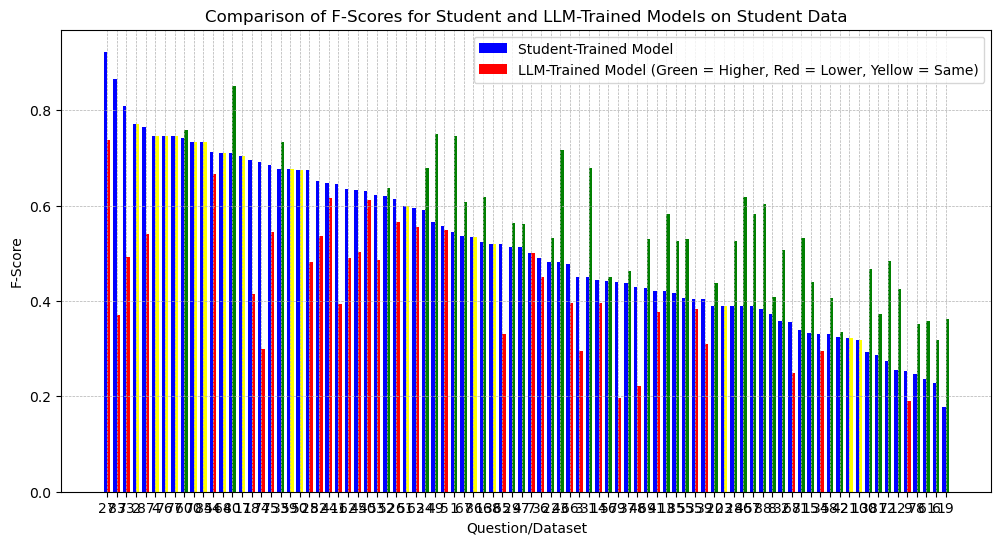

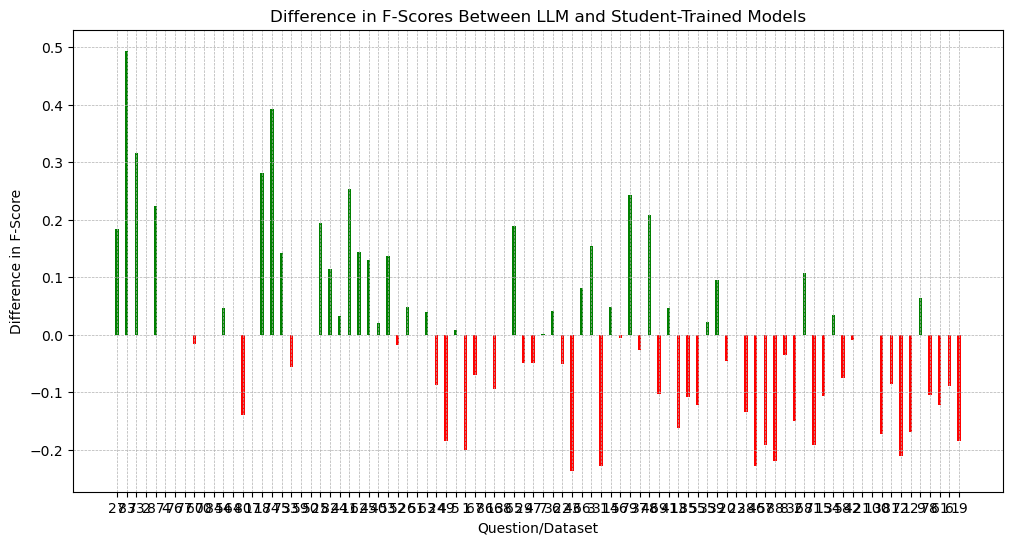

    Question  Student-Trained F-Score  LLM-Trained F-Score  \
0         27                 0.922545             0.738309   
1         83                 0.864862             0.370982   
2         73                 0.808438             0.492807   
3          2                 0.770821             0.770821   
4         87                 0.764015             0.539501   
..       ...                      ...                  ...   
83         9                 0.253509             0.190625   
84        78                 0.247273             0.351754   
85        61                 0.235833             0.358851   
86         6                 0.228571             0.317669   
87        19                 0.177641             0.362179   

    Difference (Student - LLM)  
0                     0.184237  
1                     0.493880  
2                     0.315631  
3                     0.000000  
4                     0.224513  
..                         ...  
83                    0.

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

# sklearn-warnings unterdrücken
warnings.filterwarnings("ignore", category=UserWarning)

# Relative Pfade zu den Ordnern
student_data_folder = 'Data_SRA'  # Ordner mit TSV-Dateien
llm_data_folder = 'Data_LLM'      # Ordner mit CSV-Dateien

# Liste aller TSV-Dateien im Ordner 'Data_SRA'
student_data_files = [os.path.join(student_data_folder, file) for file in os.listdir(student_data_folder) if file.endswith('.tsv')]

# Liste aller CSV-Dateien im Ordner 'Data_LLM'
llm_data_files = [os.path.join(llm_data_folder, file) for file in os.listdir(llm_data_folder) if file.endswith('.csv')]

# Listen, um die F-Scores zu speichern
f_scores_student_model = []
f_scores_llm_model = []

for student_file, llm_file in zip(student_data_files, llm_data_files):
    # Daten laden
    data_student = pd.read_csv(student_file, sep="\t")  # TSV-Dateien
    #data_llm = pd.read_csv(llm_file)                    # CSV-Dateien
    data_llm = pd.read_csv(os.path.join(llm_data_folder, student_file.split('/')[1][:-3] + 'csv'))    

    # Text preprocessing und Vektorisierung
    vectorizer = TfidfVectorizer()
    X_student = vectorizer.fit_transform(data_student['AnswerText'])
    X_llm = vectorizer.transform(data_llm['AnswerText'])

    y_student = data_student['Score']
    y_llm = data_llm['Score']

    # Einzigartige Labels extrahieren
    all_labels = set(data_student['Score']).union(set(data_llm['Score']))
    sorted_labels = sorted(all_labels)
    label_mapping = {label: index for index, label in enumerate(sorted_labels)}

    # Label-Mapping anwenden
    y_student_mapped = y_student.map(label_mapping)
    y_llm_mapped = y_llm.map(label_mapping)

    # Teil 1: Trainieren auf Studentendaten, Testen auf Studentendaten mit Leave-One-Out
    loo = LeaveOneOut()

    predictions_student = []  # Vorhersagen für den Studenten-Trainingslauf
    true_labels_student = []  # Wahre Labels

    for train_index, test_index in loo.split(X_student):
        X_train, X_test = X_student[train_index], X_student[test_index]
        y_train, y_test = y_student_mapped.iloc[train_index], y_student_mapped.iloc[test_index]

        svm_model_student = SVC(kernel='rbf')
        svm_model_student.fit(X_train, y_train)
        y_pred = svm_model_student.predict(X_test)

        # Speichere die Vorhersagen und wahren Labels
        predictions_student.append(y_pred[0])
        true_labels_student.append(y_test.iloc[0])

    # Berechne den F1-Score nach der LOO-Schleife für das Studentenmodell
    f1_student = f1_score(true_labels_student, predictions_student, average='weighted', zero_division=0)
    f_scores_student_model.append(f1_student)

    # Teil 2: Trainieren auf LLM-Daten, Testen auf Studentendaten mit Leave-One-Out
    predictions_llm = []  # Vorhersagen für den LLM-Trainingslauf
    true_labels_llm = []  # Wahre Labels (Studentendaten als Testdaten)

    for train_index, test_index in loo.split(X_student):
        X_train_llm, X_test = X_llm, X_student[test_index]
        y_train_llm, y_test = y_llm_mapped, y_student_mapped.iloc[test_index]

        svm_model_llm = SVC(kernel='rbf')
        svm_model_llm.fit(X_train_llm, y_train_llm)
        y_pred_llm = svm_model_llm.predict(X_test)

        # Speichere die Vorhersagen und wahren Labels
        predictions_llm.append(y_pred_llm[0])
        true_labels_llm.append(y_test.iloc[0])

    # Berechne den F1-Score nach der LOO-Schleife für das LLM-Modell
    f1_llm = f1_score(true_labels_llm, predictions_llm, average='weighted', zero_division=0)
    f_scores_llm_model.append(f1_llm)

# Generiere den Range für die Fragen/Datasets
questions = np.arange(1, len(f_scores_student_model) + 1)

# Plot F-Scores für das Student-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(questions, f_scores_student_model, label='Student Data F-Score', color='blue')
plt.xlabel('Question/Dataset')
plt.ylabel('F-Score')
plt.title('F-Scores for Student-Trained Model on Student Data')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

# Plot F-Scores für das LLM-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(questions, f_scores_llm_model, label='LLM Data F-Score', color='green')
plt.xlabel('Question/Dataset')
plt.ylabel('F-Score')
plt.title('F-Scores for LLM-Trained Model on Student Data')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

# Kombiniere Fragen und F-Scores in eine Liste von Tupeln
combined_scores = list(zip(questions, f_scores_student_model, f_scores_llm_model))

# Sortiere die kombinierten Scores basierend auf dem Student F-Score (größte zuerst)
sorted_combined_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)

# Entzippe die sortierte Liste zurück in separate Listen
sorted_questions, sorted_student_scores, sorted_llm_scores = zip(*sorted_combined_scores)

# In numpy Arrays umwandeln
sorted_questions = np.array(sorted_questions)
sorted_student_scores = np.array(sorted_student_scores)
sorted_llm_scores = np.array(sorted_llm_scores)

# Kombinierter Bar-Plot mit Differenzindikation
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35
ax.bar(np.arange(len(sorted_questions)) - width/2, sorted_student_scores, width, label='Student-Trained Model', color='blue')

# Differenz farblich markieren
for i, (f_student, f_llm) in enumerate(zip(sorted_student_scores, sorted_llm_scores)):
    if f_llm > f_student:
        ax.bar(i + width/2, f_llm, width, color='green')
    elif f_llm < f_student:
        ax.bar(i + width/2, f_llm, width, color='red')
    else:
        ax.bar(i + width/2, f_llm, width, color='yellow')

ax.set_xlabel('Question/Dataset')
ax.set_ylabel('F-Score')
ax.set_title('Comparison of F-Scores for Student and LLM-Trained Models on Student Data')
ax.legend(['Student-Trained Model', 'LLM-Trained Model (Green = Higher, Red = Lower, Yellow = Same)'])
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticks(np.arange(len(sorted_questions)))
ax.set_xticklabels(sorted_questions)

plt.show()

# Bar-Plot, der nur die Unterschiede zeigt
fig, ax = plt.subplots(figsize=(12, 6))

differences = [f_student - f_llm for f_student, f_llm in zip(sorted_student_scores, sorted_llm_scores)]
colors = ['green' if diff > 0 else 'red' if diff < 0 else 'yellow' for diff in differences]

ax.bar(np.arange(len(sorted_questions)), differences, width, color=colors)

ax.set_xlabel('Question/Dataset')
ax.set_ylabel('Difference in F-Score')
ax.set_title('Difference in F-Scores Between LLM and Student-Trained Models')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xticks(np.arange(len(sorted_questions)))
ax.set_xticklabels(sorted_questions)

plt.show()

# Erstelle eine Tabelle mit den F-Scores
f_scores_table = pd.DataFrame({
    'Question': sorted_questions,
    'Student-Trained F-Score': sorted_student_scores,
    'LLM-Trained F-Score': sorted_llm_scores,
    'Difference (Student - LLM)': differences
})

# Tabelle anzeigen
print(f_scores_table)


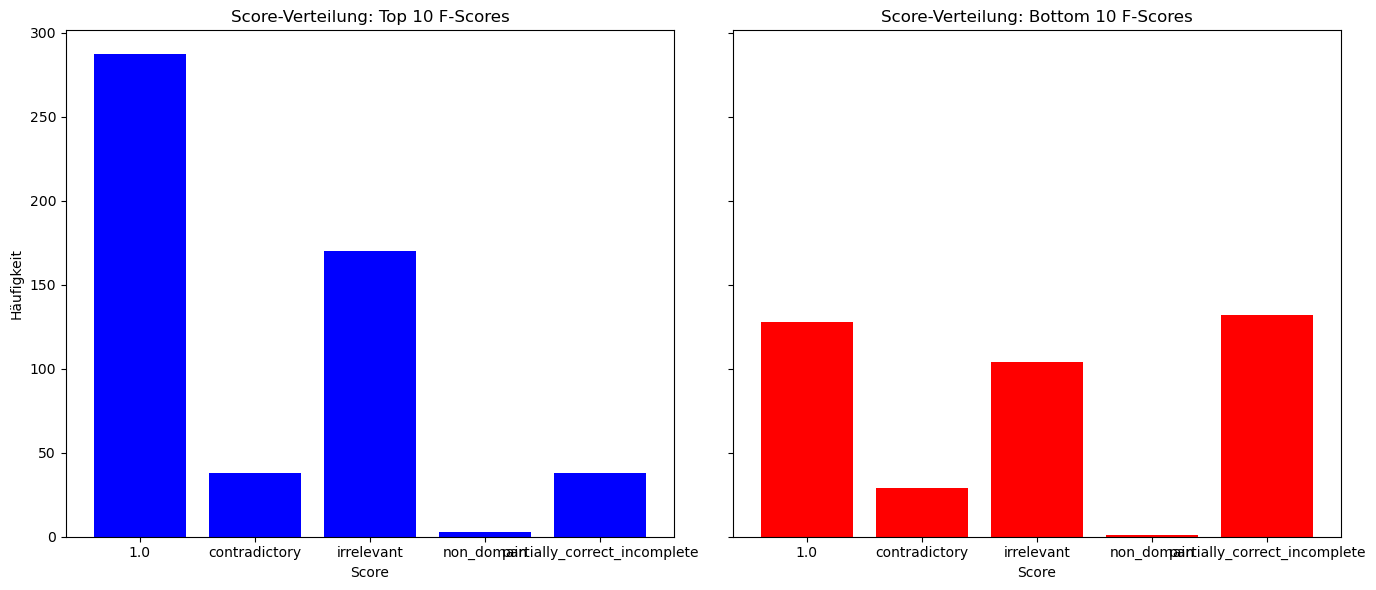

In [3]:
# Extrahiere die Indizes für die 10 höchsten und 10 niedrigsten F-Scores
top_10_indices = np.argsort(f_scores_student_model)[-10:][::-1]  # 10 höchste F-Scores
bottom_10_indices = np.argsort(f_scores_student_model)[:10]     # 10 niedrigste F-Scores

# Funktion zur Erstellung der Score-Verteilungsdaten
def get_score_distribution(indices, data_files):
    score_distributions = []
    for idx in indices:
        file_path = data_files[idx]
        data = pd.read_csv(file_path, sep="\t")
        score_distributions.append(data['Score'].value_counts())
    return score_distributions

# Verteilungen für die höchsten und niedrigsten F-Scores
top_10_distributions = get_score_distribution(top_10_indices, student_data_files)
bottom_10_distributions = get_score_distribution(bottom_10_indices, student_data_files)

# Kombinierte Verteilungen erstellen
def combine_distributions(distributions):
    combined = pd.DataFrame(distributions).fillna(0).sum()
    combined = combined.sort_index()  # Sortiere nach Score-Werten
    return combined

top_10_combined = combine_distributions(top_10_distributions)
bottom_10_combined = combine_distributions(bottom_10_distributions)

# Visualisierung der Verteilungen
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Verteilung für die höchsten F-Scores
axes[0].bar(top_10_combined.index, top_10_combined.values, color='blue')
axes[0].set_title("Score-Verteilung: Top 10 F-Scores")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Häufigkeit")

# Verteilung für die niedrigsten F-Scores
axes[1].bar(bottom_10_combined.index, bottom_10_combined.values, color='red')
axes[1].set_title("Score-Verteilung: Bottom 10 F-Scores")
axes[1].set_xlabel("Score")

plt.tight_layout()
plt.show()


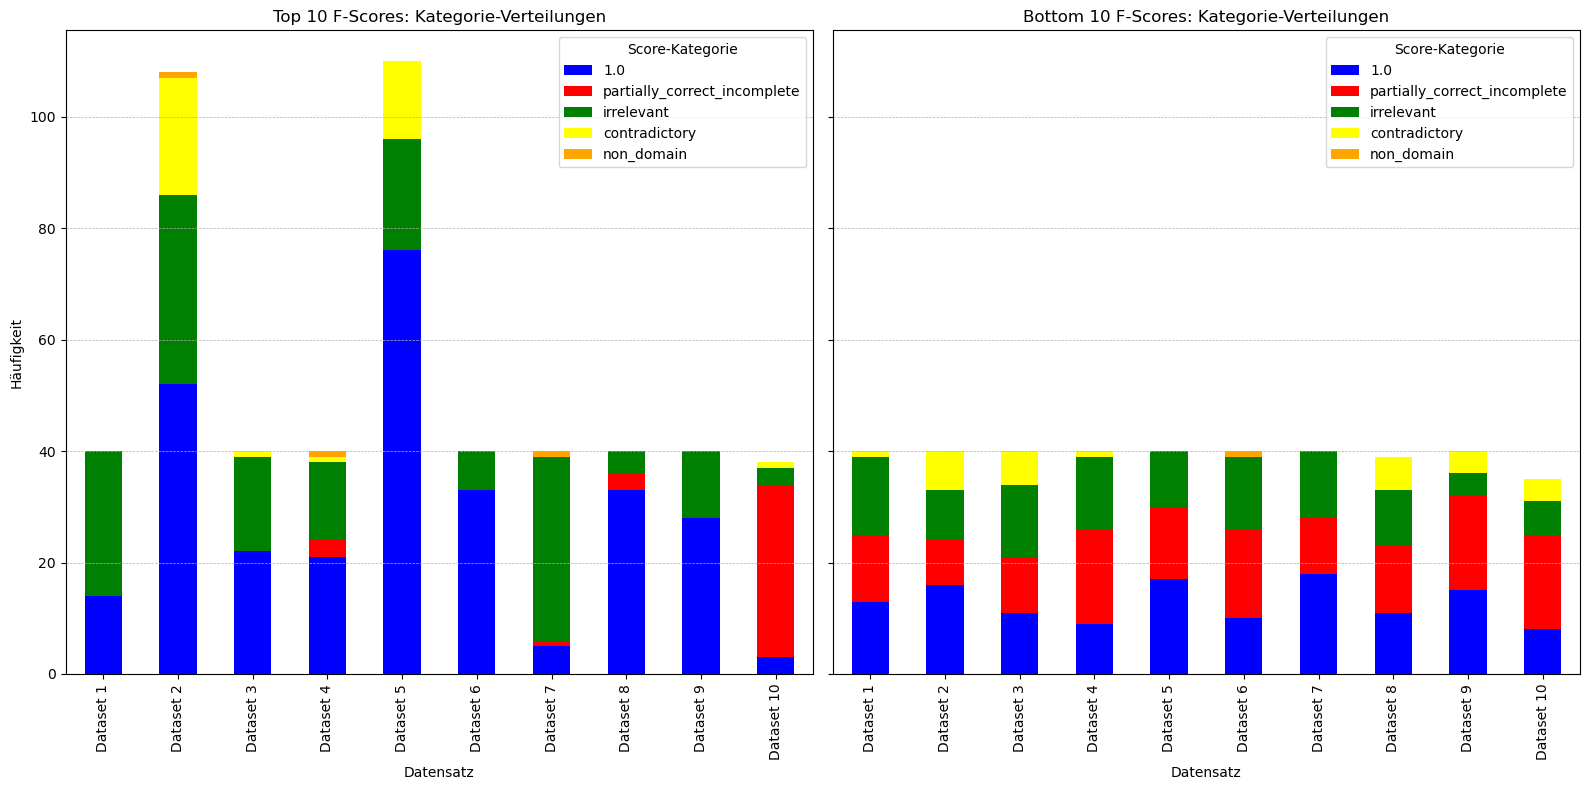

Top 10 F-Scores:
   Dataset                        Filename  F-Score
 Dataset 1 SRA_allAnswers_promptMS_43b.tsv 0.922545
 Dataset 2  SRA_allAnswers_promptPS_2a.tsv 0.864862
 Dataset 3 SRA_allAnswers_promptMS_50a.tsv 0.808438
 Dataset 4   SRA_allAnswers_promptVB_1.tsv 0.770821
 Dataset 5  SRA_allAnswers_promptPS_2b.tsv 0.764015
 Dataset 6 SRA_allAnswers_promptFN_27b.tsv 0.745890
 Dataset 7 SRA_allAnswers_promptEM_45c.tsv 0.745890
 Dataset 8 SRA_allAnswers_promptMS_64a.tsv 0.745890
 Dataset 9 SRA_allAnswers_promptFN_17a.tsv 0.741176
Dataset 10 SRA_allAnswers_promptLF_31b.tsv 0.733028

Bottom 10 F-Scores:
   Dataset                         Filename  F-Score
 Dataset 1  SRA_allAnswers_promptII_24b.tsv 0.177641
 Dataset 2  SRA_allAnswers_promptLF_13a.tsv 0.228571
 Dataset 3   SRA_allAnswers_promptSE_44.tsv 0.235833
 Dataset 4   SRA_allAnswers_promptEM_46.tsv 0.247273
 Dataset 5   SRA_allAnswers_promptMS_39.tsv 0.253509
 Dataset 6 SRA_allAnswers_promptLF_26a2.tsv 0.254654
 Dataset 7  SRA_all

In [4]:
# Farben für die Kategorien definieren
category_colors = {
    "1.0": "blue",
    "partially_correct_incomplete": "red",
    "irrelevant": "green",
    "contradictory": "yellow",
    "non_domain": "orange"
}

# Funktion zur Erstellung der Kategorie-Verteilungen für einzelne Indizes
def get_category_distributions(indices, data_files):
    distributions = []
    for idx in indices:
        file_path = data_files[idx]
        data = pd.read_csv(file_path, sep="\t")
        category_counts = data['Score'].value_counts().reindex(category_colors.keys(), fill_value=0)
        distributions.append(category_counts)
    return pd.DataFrame(distributions).fillna(0).reset_index(drop=True)

# Verteilungen für die höchsten und niedrigsten F-Scores
top_10_categories = get_category_distributions(top_10_indices, student_data_files)
bottom_10_categories = get_category_distributions(bottom_10_indices, student_data_files)

# Funktion zur Visualisierung der Kategorie-Verteilungen
def plot_category_distributions(data, title, ax):
    data.index = [f"Dataset {i+1}" for i in range(len(data))]
    data.plot(
        kind="bar",
        stacked=True,
        color=[category_colors[cat] for cat in data.columns],
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Datensatz")
    ax.set_ylabel("Häufigkeit")
    ax.legend(title="Score-Kategorie")
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Top 10 F-Scores
plot_category_distributions(top_10_categories, "Top 10 F-Scores: Kategorie-Verteilungen", axes[0])

# Bottom 10 F-Scores
plot_category_distributions(bottom_10_categories, "Bottom 10 F-Scores: Kategorie-Verteilungen", axes[1])

plt.tight_layout()
plt.show()


# Erstelle eine Tabelle für die höchsten F-Scores
top_10_table = pd.DataFrame({
    "Dataset": [f"Dataset {i+1}" for i in range(10)],
    "Filename": [os.path.basename(student_data_files[idx]) for idx in top_10_indices],
    "F-Score": [f_scores_student_model[idx] for idx in top_10_indices]
})

# Erstelle eine Tabelle für die niedrigsten F-Scores
bottom_10_table = pd.DataFrame({
    "Dataset": [f"Dataset {i+1}" for i in range(10)],
    "Filename": [os.path.basename(student_data_files[idx]) for idx in bottom_10_indices],
    "F-Score": [f_scores_student_model[idx] for idx in bottom_10_indices]
})

# Ausgabe der Tabellen
print("Top 10 F-Scores:")
print(top_10_table.to_string(index=False))

print("\nBottom 10 F-Scores:")
print(bottom_10_table.to_string(index=False))
